<a href="https://colab.research.google.com/github/Shreya-singh01/Anti-Spoofing-Detector/blob/main/Anti_Spoofing_Detector.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install ultralytics
!pip install cvzone
!pip install opencv-python-headless
!pip install mediapipe

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 41.3/41.3 kB 1.2 MB/s eta 0:00:00
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_nccl_cu12-2.20.5-py3-none-manylinux2014_x86_64.

In [2]:
!git clone --depth 1 --filter=blob:none --sparse https://github.com/Shreya-singh01/Anti-Spoofing-Detector.git
%cd Anti-Spoofing-Detector
!git sparse-checkout set collected_images

Cloning into 'Anti-Spoofing-Detector'...
remote: Enumerating objects: 25, done.
remote: Counting objects: 100% (25/25), done.
remote: Compressing objects: 100% (25/25), done.
remote: Total 25 (delta 0), reused 25 (delta 0), pack-reused 0
Receiving objects: 100% (25/25), 213.98 KiB | 3.75 MiB/s, done.
remote: Enumerating objects: 2, done.
remote: Counting objects: 100% (2/2), done.
remote: Total 2 (delta 0), reused 2 (delta 0), pack-reused 0
Receiving objects: 100% (2/2), 324.11 KiB | 6.12 MiB/s, done.
/content/Anti-Spoofing-Detector
remote: Enumerating objects: 8536, done.
remote: Counting objects: 100% (8536/8536), done.
remote: Compressing objects: 100% (8536/8536), done.
remote: Total 8536 (delta 0), reused 8536 (delta 0), pack-reused 0
Receiving objects: 100% (8536/8536), 46.76 MiB | 30.77 MiB/s, done.
Updating files: 100% (8743/8743), done.


In [25]:
#DATA COLLECTION WITH LABELS
from google.colab import output
from IPython.display import display, Javascript
from google.colab.output import eval_js
from base64 import b64decode
import cv2
import numpy as np
import os

# Function to capture images and save them with labels
def take_photo(label, filename='photo.jpg', quality=0.8):
    js = Javascript('''
        async function takePhoto(quality) {
            const div = document.createElement('div');
            const capture = document.createElement('button');
            capture.textContent = 'Capture';
            div.appendChild(capture);
            document.body.appendChild(div);

            // Load the webcam
            const video = document.createElement('video');
            video.style.display = 'block';
            const stream = await navigator.mediaDevices.getUserMedia({video: true});
            document.body.appendChild(video);
            video.srcObject = stream;
            await new Promise((resolve) => {
                video.onloadedmetadata = () => {
                    resolve(video);
                };
            });
            video.play();

            // Capture the photo when the button is clicked
            await new Promise((resolve) => capture.onclick = resolve);

            const canvas = document.createElement('canvas');
            canvas.width = video.videoWidth;
            canvas.height = video.videoHeight;
            canvas.getContext('2d').drawImage(video, 0, 0);
            stream.getVideoTracks()[0].stop();
            const data = canvas.toDataURL('image/jpeg', quality);
            div.remove();
            video.remove();
            return data;
        }
        ''')
    display(js)
    data = eval_js('takePhoto({})'.format(quality))
    binary = b64decode(data.split(',')[1])

    # Define directory based on label
    label_dir = os.path.join("collected_images", label)
    os.makedirs(label_dir, exist_ok=True)

    with open(os.path.join(label_dir, filename), 'wb') as f:
        f.write(binary)
    print(f"Saved {filename} in {label_dir}")

# Collect 'real' images (with person present)
for i in range(5):  # Change the range to collect more images
    take_photo(label="real", filename=f'real_{i}.jpg')

# Collect 'fake' images (with a photo on a mobile phone)
for i in range(5):  # Change the range to collect more images
    take_photo(label="fake", filename=f'fake_{i}.jpg')


<IPython.core.display.Javascript object>

Saved real_0.jpg in collected_images/real


<IPython.core.display.Javascript object>

Saved real_1.jpg in collected_images/real


<IPython.core.display.Javascript object>

Saved real_2.jpg in collected_images/real


<IPython.core.display.Javascript object>

Saved real_3.jpg in collected_images/real


<IPython.core.display.Javascript object>

Saved real_4.jpg in collected_images/real


<IPython.core.display.Javascript object>

Saved fake_0.jpg in collected_images/fake


<IPython.core.display.Javascript object>

Saved fake_1.jpg in collected_images/fake


<IPython.core.display.Javascript object>

Saved fake_2.jpg in collected_images/fake


<IPython.core.display.Javascript object>

Saved fake_3.jpg in collected_images/fake


<IPython.core.display.Javascript object>

Saved fake_4.jpg in collected_images/fake


In [3]:
import os
import shutil
from sklearn.model_selection import train_test_split

# Directories for labeled data
real_dir = os.path.join('collected_images', 'real')
fake_dir = os.path.join('collected_images', 'fake')

# Output directories for train, validation, and test sets
split_data_dir = 'SplitData'
train_dir = os.path.join(split_data_dir, 'train')
val_dir = os.path.join(split_data_dir, 'val')
test_dir = os.path.join(split_data_dir, 'test')

# Create directories if they don't exist
os.makedirs(train_dir, exist_ok=True)
os.makedirs(val_dir, exist_ok=True)
os.makedirs(test_dir, exist_ok=True)

def get_all_images_from_subdirs(main_dir):
    images = []
    for subdir in sorted(os.listdir(main_dir)):
        subdir_path = os.path.join(main_dir, subdir)
        if os.path.isdir(subdir_path):
            images.extend([os.path.join(subdir_path, f) for f in os.listdir(subdir_path) if f.endswith('.jpg')])
    return images

# Get the list of image files for each label from subdirectories 0001 to 0010
real_images = get_all_images_from_subdirs(real_dir)
fake_images = get_all_images_from_subdirs(fake_dir)

# Split real images into train, validation, and test sets
real_train, real_val_test = train_test_split(real_images, test_size=0.3, random_state=42)
real_val, real_test = train_test_split(real_val_test, test_size=0.5, random_state=42)

# Split fake images into train, validation, and test sets
fake_train, fake_val_test = train_test_split(fake_images, test_size=0.3, random_state=42)
fake_val, fake_test = train_test_split(fake_val_test, test_size=0.5, random_state=42)

# Helper function to save split data into respective directories
def save_split(images, directory, label):
    label_dir = os.path.join(directory, label)
    os.makedirs(label_dir, exist_ok=True)
    for img_path in images:
        shutil.copy(img_path, label_dir)

# Save the splits into train, validation, and test directories under SplitData
save_split(real_train, train_dir, 'real')
save_split(fake_train, train_dir, 'fake')

save_split(real_val, val_dir, 'real')
save_split(fake_val, val_dir, 'fake')

save_split(real_test, test_dir, 'real')
save_split(fake_test, test_dir, 'fake')

print("Data has been successfully split and saved into the SplitData directory.")


Data has been successfully split and saved into the SplitData directory.


In [4]:
#TRAINING THE MODEL
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Image data generators
train_datagen = ImageDataGenerator(rescale=1./255)
val_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    '/content/Anti-Spoofing-Detector/SplitData/train',
    target_size=(64, 64),
    batch_size=16,
    class_mode='binary'
)

val_generator = val_datagen.flow_from_directory(
    '/content/Anti-Spoofing-Detector/SplitData/val',
    target_size=(64, 64),
    batch_size=16,
    class_mode='binary'
)

# Build the model
model = models.Sequential([
    layers.Conv2D(32, (3, 3), activation='relu', input_shape=(64, 64, 3)),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(128, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dense(1, activation='sigmoid')  # Binary output for real/fake
])

# Compile the model
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

# Train the model
model.fit(
    train_generator,
    steps_per_epoch=370,
    epochs=20,
    validation_data=val_generator,
    validation_steps=79
)


Found 6109 images belonging to 2 classes.
Found 1309 images belonging to 2 classes.


/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/20


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


370/370 ━━━━━━━━━━━━━━━━━━━━ 53s 136ms/step - accuracy: 0.8732 - loss: 0.2998 - val_accuracy: 0.9929 - val_loss: 0.0295
Epoch 2/20
370/370 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 1.0000 - loss: 0.0127 - val_accuracy: 1.0000 - val_loss: 0.0033
Epoch 3/20


/usr/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


370/370 ━━━━━━━━━━━━━━━━━━━━ 79s 135ms/step - accuracy: 0.9903 - loss: 0.0331 - val_accuracy: 0.9968 - val_loss: 0.0121
Epoch 4/20
370/370 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9844 - loss: 0.0214 - val_accuracy: 1.0000 - val_loss: 0.0030
Epoch 5/20
370/370 ━━━━━━━━━━━━━━━━━━━━ 51s 138ms/step - accuracy: 0.9975 - loss: 0.0104 - val_accuracy: 0.9984 - val_loss: 0.0080
Epoch 6/20
370/370 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 1.0000 - loss: 1.0036e-04 - val_accuracy: 1.0000 - val_loss: 1.1633e-04
Epoch 7/20
370/370 ━━━━━━━━━━━━━━━━━━━━ 83s 145ms/step - accuracy: 0.9892 - loss: 0.0297 - val_accuracy: 0.9984 - val_loss: 0.0137
Epoch 8/20
370/370 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.9949 - loss: 0.0080 - val_accuracy: 1.0000 - val_loss: 0.0146
Epoch 9/20
370/370 ━━━━━━━━━━━━━━━━━━━━ 52s 140ms/step - accuracy: 0.9956 - loss: 0.0105 - val_accuracy: 0.9739 - val_loss: 0.0999
Epoch 10/20
370/370 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 1.0000 - loss: 0.0022 - val_ac

In [5]:
# Evaluate the model on the test set
test_generator = test_datagen.flow_from_directory(
    '/content/Anti-Spoofing-Detector/SplitData/test',
    target_size=(64, 64),
    batch_size=32,
    class_mode='binary'
)

test_loss, test_acc = model.evaluate(test_generator, steps=len(test_generator))
print(f"Test Accuracy: {test_acc}")

# Save the model for future use
model.save('anti_spoofing_model.h5')


Found 1311 images belonging to 2 classes.
41/41 ━━━━━━━━━━━━━━━━━━━━ 4s 104ms/step - accuracy: 0.9978 - loss: 0.0031


Test Accuracy: 0.9984744191169739


In [6]:
# Testing the model on a sample image
import numpy as np
from tensorflow.keras.preprocessing import image

# def predict_image(img_path, threshold=0.5):
#     img = image.load_img(img_path, target_size=(64, 64))
#     img_array = image.img_to_array(img)
#     img_array = np.expand_dims(img_array, axis=0) / 255.0
#     prediction = model.predict(img_array)
#     print(f"Raw Prediction: {prediction[0][0]}")  # Add this line for debugging
#     if prediction[0][0] > 0.5:
#         print(f"{img_path} is predicted as Real (1)")
#     else:
#         print(f"{img_path} is predicted as Fake (0)")



def preprocess_image(img_path):
    img = image.load_img(img_path, target_size=(64, 64))
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0) / 255.0
    return img_array

def predict_image(img_path):
    img_array = preprocess_image(img_path)
    prediction = model.predict(img_array)
    if prediction[0][0] > 0.5:
        print(f"{img_path} is predicted as Real (1)")
    else:
        print(f"{img_path} is predicted as Fake (0)")
    print(f"Confidence: {prediction[0][0]}")

# Replace 'path_to_image' with the path to an image you want to test
predict_image('/content/Anti-Spoofing-Detector/collected_images/fake/0004/0004_01_00_01_125.jpg')

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step
/content/Anti-Spoofing-Detector/collected_images/fake/0004/0004_01_00_01_125.jpg is predicted as Fake (0)
Confidence: 1.1840686653386001e-08


In [7]:
# Replace 'path_to_image' with the path to an image you want to test
predict_image('/content/Anti-Spoofing-Detector/collected_images/real/0007/0007_00_00_01_101.jpg')

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
/content/Anti-Spoofing-Detector/collected_images/real/0007/0007_00_00_01_101.jpg is predicted as Real (1)
Confidence: 1.0


In [9]:
import cv2
import numpy as np
from tensorflow.keras.preprocessing import image

<IPython.core.display.Javascript object>

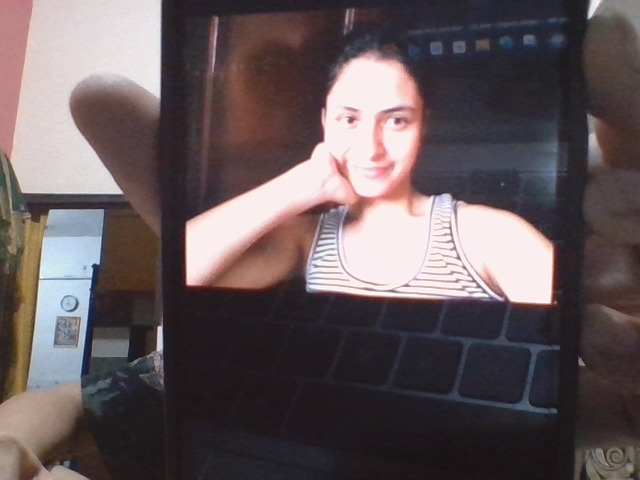

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
captured_image.jpg is predicted as Fake (0)
Confidence: 1.7334337090724183e-11


In [15]:
from IPython.display import display, Javascript
from google.colab.output import eval_js
from base64 import b64decode
import numpy as np
import cv2
from PIL import Image
from io import BytesIO

def capture_image():
    js = Javascript('''
        async function takePhoto() {
            const div = document.createElement('div');
            const capture = document.createElement('button');
            capture.textContent = 'Capture';
            div.appendChild(capture);
            document.body.appendChild(div);

            const video = document.createElement('video');
            video.style.display = 'block';
            const stream = await navigator.mediaDevices.getUserMedia({video: true});
            document.body.appendChild(video);
            video.srcObject = stream;
            await new Promise((resolve) => video.onloadedmetadata = () => resolve());
            video.play();

            await new Promise((resolve) => capture.onclick = resolve);

            const canvas = document.createElement('canvas');
            canvas.width = video.videoWidth;
            canvas.height = video.videoHeight;
            canvas.getContext('2d').drawImage(video, 0, 0);
            stream.getTracks().forEach(track => track.stop());
            video.remove();
            div.remove();
            return canvas.toDataURL('image/jpeg').replace(/^data:image\\/jpeg;base64,/, '');
        }
        ''')
    display(js)
    data = eval_js('takePhoto()')
    img = Image.open(BytesIO(b64decode(data)))
    return img

# Capture the image
img = capture_image()

# Convert the image to an OpenCV format
img = np.array(img)
img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)

# Save the captured image
cv2.imwrite('captured_image.jpg', img)

# Display the image
from google.colab.patches import cv2_imshow
cv2_imshow(img)
predict_image('captured_image.jpg')
